In [1]:
import pandas as pd
import numpy as np
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode

import warnings
warnings.filterwarnings('ignore')

sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(12,8)}
        )

## Задание 1
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

В качестве входных данных Вы имеете 4 csv-файла:

* `groups.csv` - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* `groups_add.csv` - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* `active_studs.csv` - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* `checks.csv` - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

Предлагаем Вам ответить на следующие вопросы:

1. На какие метрики Вы смотрите в ходе анализа и почему?
2. Имеются ли различия в показателях и с чем они могут быть связаны?
3. Являются ли эти различия статистически значимыми?
4. Стоит ли запускать новую механику на всех пользователей?
5. Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

### **Порядок работы**
1. Загружаем данные
2. Покрутим данные - проверка на дубликаты, пропуски, пересечения в группах
3. Предобработка данных для анализа
4. Определяем ключевые метрики для анализа
5. Стат. тесты - формулируем гипотезу, выбираем стат. тест, тестируем
6. Выводы

### Загружаем данные

In [2]:
# Функция для считывания данных с Яндекс.Диска
def get_data(df_url, sep=';'):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=df_url))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его
    df = pd.read_csv(download_url, sep=sep)
    
    return df

In [3]:
groups_url = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
group_add_url = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
active_studs_url = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
checks_url = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

In [4]:
# Считаем данные

groups = get_data(groups_url)
active_studs = get_data(active_studs_url)
checks = get_data(checks_url)
groups_add = get_data(group_add_url, sep=',')

### Крутим данные

In [5]:
# Напишем функцию для проверки данных

def df_info(df):
    '''Принимает датафрейм и возвращает количество строк и колонок в нем, типы данных, 
       название колонок с пропущенными значениями и их количество, а также колонки с дубликатами'''
    
    # Размер датафрейма
    nrows = df.shape[0]
    ncolumns = df.shape[1]
    # Типы данных
    d_types = df.dtypes
    # Пропуски
    df_nan = df.isna().sum()
    
    # Определяем колонки с дубликатами
    columns_with_duplicates = []
    cols = df.columns
    for i in range(ncolumns):
        if df.iloc[:, i].nunique() != nrows:
            columns_with_duplicates.append(cols[i])
        continue
    
    print(f'Количество строк: {nrows}', f'Количество столбцов: {ncolumns}', sep='\n', end='\n\n')
    print(f'Типы данных:', d_types, sep='\n', end='\n\n')
    print(f'Пропущенные значения:', df_nan, sep='\n', end='\n\n')            
    print(f'Колонки, в которых есть дубликаты: {columns_with_duplicates}')
    
    return df.sample(5)

In [6]:
df_info(groups)

Количество строк: 74484
Количество столбцов: 2

Типы данных:
id      int64
grp    object
dtype: object

Пропущенные значения:
id     0
grp    0
dtype: int64

Колонки, в которых есть дубликаты: ['grp']


,id,grp
15777,734018,B
32576,1465451,B
57922,3457867,B
24987,1163428,A
5775,318425,B


In [7]:
df_info(groups_add)

Количество строк: 92
Количество столбцов: 2

Типы данных:
id      int64
grp    object
dtype: object

Пропущенные значения:
id     0
grp    0
dtype: int64

Колонки, в которых есть дубликаты: ['grp']


,id,grp
78,5951797,B
70,5838604,B
41,5724736,B
59,5760471,B
47,5729681,B


In [8]:
df_info(active_studs)

Количество строк: 8341
Количество столбцов: 1

Типы данных:
student_id    int64
dtype: object

Пропущенные значения:
student_id    0
dtype: int64

Колонки, в которых есть дубликаты: []


,student_id
3589,262341
4161,291171
3940,1087607
4360,634007
5409,5008392


In [9]:
df_info(checks)

Количество строк: 541
Количество столбцов: 2

Типы данных:
student_id      int64
rev           float64
dtype: object

Пропущенные значения:
student_id    0
rev           0
dtype: int64

Колонки, в которых есть дубликаты: ['rev']


,student_id,rev
99,459612,690.0
475,4875778,1900.0
136,991392,398.0
133,926967,1900.0
309,3117959,199.0


In [10]:
# Пока что ничего аномального в данных нет

checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

### Предобработка данных

In [11]:
# Объединим исходные данные по принадлежности пользователей с дополненными
groups_full = pd.concat([groups, groups_add])

# Переименуем колонки 
groups_full.rename(columns={'id': 'student_id'}, inplace=True)

In [12]:
# Дубликатов в студентах нет

groups_full.student_id.duplicated().sum()

0

In [13]:
# Посмотрим, есть ли пользователи с оплатой, но не отмеченные как активные

active_studs['act_flag'] = 1

bag_users = checks.merge(active_studs, how='left', on='student_id').query('act_flag != 1')
bag_users.shape[0]

# Имеем 149 пользователей с оплатой, но не отмеченных как активные. 
# Похоже на ошибку логирования либо на этапе оплаты,
# либо на этапе контроля активности. Не будем выкидывать этих пользователей из анализа

149

In [14]:
# Поработаем с баговаными
bag_users = bag_users.merge(groups_full, how='left', on='student_id')

bag_users.act_flag = 1

In [15]:
# Возьмем в анализ только активных студентов на период проведения теста и добавим к ним инфо об оплате
data = active_studs.merge(groups_full, how='left', on='student_id') \
                   .merge(checks, how='left', on='student_id')


data = pd.concat([data, bag_users])

# Заполним наны нулями (0 = пользователь не совершил оплаты в указанный период)
data.rev.fillna(0, inplace=True)

In [16]:
# Посмотрим на размер групп
data.grp.value_counts()

B    6923
A    1567
Name: grp, dtype: int64

### Определяем ключевые метрики

Исходя из наших данных можно выбрать две ключевые метрики - средний чек и конверсия в покупку

Произведем расчет метрик

In [17]:
data.head()

,student_id,act_flag,grp,rev
0,581585,1,A,0.0
1,5723133,1,A,0.0
2,3276743,1,B,0.0
3,4238589,1,A,0.0
4,4475369,1,B,0.0


In [18]:
# Количество пользователей в группах

nstudents = data.groupby('grp', as_index=False) \
                .agg({'student_id': 'count'}) \
                .rename(columns={'student_id': 'students'})

nstudents

,grp,students
0,A,1567
1,B,6923


In [19]:
# Количество платящих пользователей в группах

ncustomers = data[data.rev > 0].groupby('grp', as_index=False) \
                .agg({'student_id': 'count'}) \
                .rename(columns={'student_id': 'customers'})

ncustomers

,grp,customers
0,A,107
1,B,434


In [20]:
# Суммарный доход по группам

revenue = data.groupby('grp', as_index=False) \
              .agg({'rev': 'sum'})

revenue

,grp,rev
0,A,92096.0000
1,B,481230.0036


In [21]:
# Объединяем

metrics = nstudents.merge(ncustomers).merge(revenue)

In [22]:
# Считаем метрики - конверсию в покупку, средний чек, ARPU (средний доход на студента)

metrics['cr'] = metrics.customers.div(metrics.students)

metrics['avg_check'] = metrics.rev.div(metrics.customers).round(2)

metrics['ARPU'] = metrics.rev.div(metrics.students).round(2)

In [23]:
metrics

,grp,students,customers,rev,cr,avg_check,ARPU
0,A,1567,107,92096.0000,0.068283,860.71,58.77
1,B,6923,434,481230.0036,0.062690,1108.82,69.51


Протеворечивая ситуация - после ввода новой системы оплаты мы получили снижение конверсии в покупку, но средний чек и доходы с одного студента выросли

In [24]:
# Падение конверсии составило 8,2%

(1 - metrics.loc[1, 'cr'] / metrics.loc[0, 'cr']) * 100

8.191980949321042

In [25]:
# Прирост суммы среднего чека 28,8%

(1 - metrics.loc[1, 'avg_check'] / metrics.loc[0, 'avg_check']) * 100

-28.826201624240433

### Применение стат. тестов

In [26]:
# Посмотрим на данные

control = data.query('grp == "A" and rev > 0')
test    = data.query('grp == "B" and rev > 0')

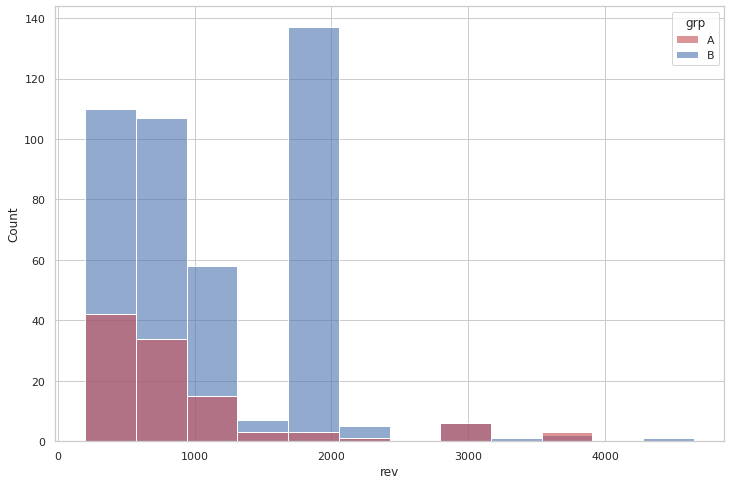

In [27]:
# Распределение явно отличается от нормального. Скошено вправо, что характерно для распределения суммы покупок

sns.histplot(data = data[data.rev > 0], 
              x='rev', 
              hue='grp', 
              palette = ['r', 'b'],
              alpha=0.6)

Также в тестовой группе наблюдается ярко выраженное пиковое значение суммы покупок в ройоне 1900, что существенно отличает анализируемые распределения. 
Тяжело сказать что-то опричинах такого пика, т.к. в подробностях ничего неизвестно о новой механике оплаты, как и о платящей аудитории. 
Возможно, это как раз связано с особенностями новой механики оплаты - были предложены дополнительные бонусы при оплате на определенную сумму.
Также возможен вариант неидеальной работы системы сплитования, когда в тестовую группу попала большая доля пользователей, заинтересованная в приобритении какого-то курса стоимостью 1900

Сложно сказать, никакого контекста относительно проводимого эсксперимента не приведено

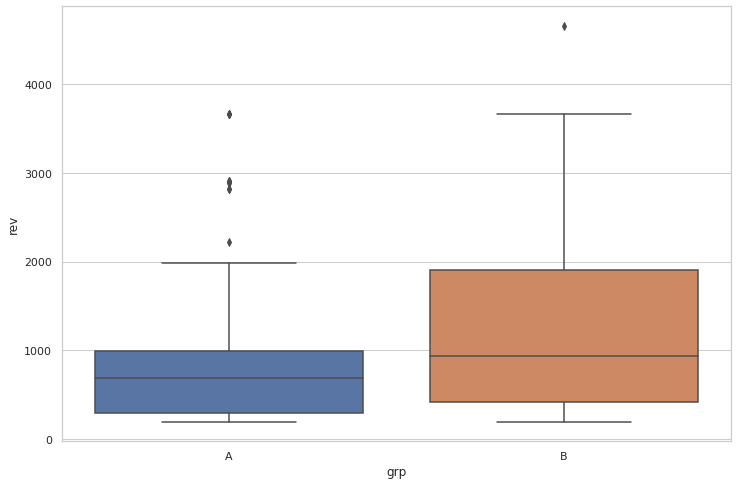

In [28]:
# Боксплот подтверждает наши расчеты о наличии прироста суммы покупок в тестовой группе
# Есть выбросы, но их трудно так классфицировать. Скорее это более обеспеченные или усердные студеты

sns.boxplot(data=data[data.rev > 0], x='grp', y='rev')

Т.к. распределения в выборках не являются нормальными + у нас значительные различия по размеру групп, для определения стат.значимости различий распределений в контрольной и тестовой группах воспользуемся непараметрическим аналогом t-теста - тестом Манна-Уитни

**H0:** Распределения суммы покупок в контрольной и тестовой группе не различается

**H1:** Различие в распределениях сумм покупок в контрольной и тестовой группах есть

In [29]:
# Для оценки берем только платящих пользователей

pg.mwu(control.rev, test.rev)

,U-val,alternative,p-val,RBC,CLES
MWU,17862.0,two-sided,0.000193,0.230716,0.384642


Критерий Манна-Уитни показал значимые различия - принимаем альтернативную гипотезу

Для понимания, как именно различаются наши группы воспользуемся бутстрапом. Для оценки различия двух групп сначала посмотрим на **разницу медиан**

In [30]:
from bootstrap import get_bootstrap

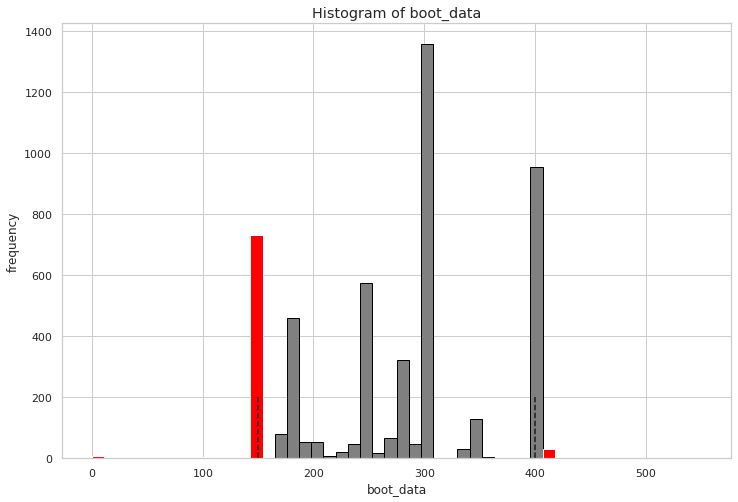

In [31]:
bs_median = get_bootstrap(test.rev, control.rev, statistic=np.median, boot_it=5000)

In [32]:
bs_median['p_value']

0.0032

In [33]:
bs_median['ci']

,0
0.025,150.0
0.975,400.0


p-value < 0.05, медианный чек стат. значимо вырос

И посмотрим на разницу **средних значений**. Также применим бутстрап

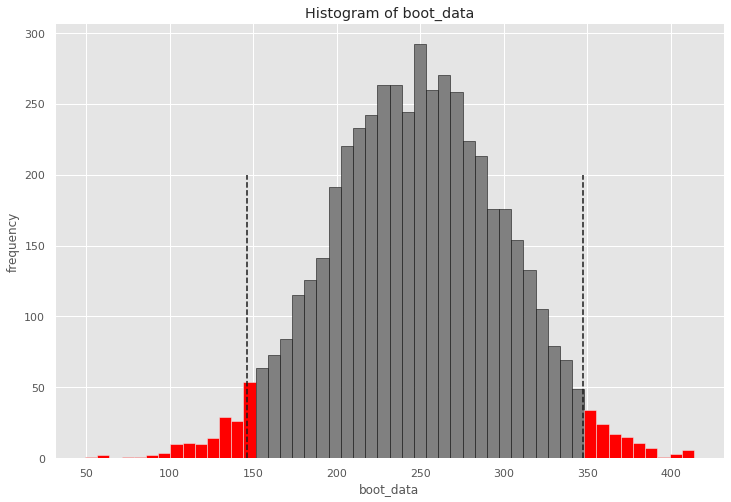

In [34]:
bs_mean = get_bootstrap(test.rev, control.rev, statistic=np.mean, boot_it=5000)

In [35]:
bs_mean['p_value_norm'] # распределение разниц нормально. используем вариант расчета p-value через normal.cdf

1.9722596077637944e-06

In [36]:
bs_mean['ci']

,0
0.025,146.004559
0.975,347.174954


p-value < 0.05, средний чек стат. значимо вырос

Для определения стат. значимости снижения конверсии студента в платящего воспользуемся критерием хи-квадрат, т.к. имеем категориальные данные

**H0:** Взаимосвязь между системой оплаты и конверсией отсутствует

**H1:** Взаимосвязь между системой оплаты и конверсией есть

In [37]:
# Добавим колонку со статусом покупки

data['pay'] = data.rev > 0

In [38]:
expected, observed, stats = pg.chi2_independence(data, x='grp', y='pay', correction=False)

In [39]:
observed

pay,False,True
grp,,
A,1460,107
B,6489,434


In [40]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.670145,1.0,0.413001,0.008884,0.129594
1,cressie-read,0.666667,0.666397,1.0,0.414311,0.008860,0.129137
2,log-likelihood,0.000000,0.659040,1.0,0.416899,0.008811,0.128241
3,freeman-tukey,-0.500000,0.653642,1.0,0.418814,0.008774,0.127583
4,mod-log-likelihood,-1.000000,0.648343,1.0,0.420706,0.008739,0.126938
5,neyman,-2.000000,0.638037,1.0,0.424423,0.008669,0.125683


p-value > 0.05 => нет основания отклонить нулевую гипотезу.

### Выводы
1. Средний чек в тестовой группе вырос на 28,8 %. Стат. тесты Манна-Уитни и метод бутстрапа показали статистически значимый прирост среднего чека
2. Конверсия снизилась на 8,2 %. Критерий хи-квадрат не показал, что падение конверсии статистически значимо
3. На этапе проверки данных было выявлено 149 платящих пользователей, не отмеченных как активные. Нужно дать сигнал разработчикам проверить систему логирования и найти ошибку
4. Т.к. средний чек на студента вырос, а конверсия снизилась незначительно, рекомендуется внедрять новую механику оплаты

____________

## Задание 3

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [41]:
def updade_data(groups_add, groups=groups, 
                active_studs=active_studs, checks=checks):
    
    '''Функция для автоматической подгрузки информации и расчета метрик. Приниммает: 
    groups_add - df с дополненными данными о принадлежности пользователей к группам ['student_id', 'group'],
    groups - df с данными о принадлежности пользователей к группам ['student_id', 'group'],
    active_studs - df с данными об активности пользователей ['student_id'],
    checks - df с информацией об оплатах ['student_id', 'rev']'''
    
    # Подготовка данных
    groups_add.rename(columns={groups_add.columns[0]: 'student_id', 
                               groups_add.columns[1]: 'grp'}, inplace=True)
    groups.rename(columns={'id': 'student_id'}, inplace=True)
    
    # Собираем студентов вместе
    groups_full = pd.concat([groups, groups_add])
    
    # Работа с баговаными студентами
    active_studs['act_flag'] = 1

    bag_users = checks.merge(active_studs, how='left', on='student_id').query('act_flag != 1')
    nbag_users = bag_users.shape[0]
    if nbag_users != 0:
        print(f'Ошибка в логах. Есть {nbag_users} студентов с оплатой не отмеченные как активные')
    bag_users = bag_users.merge(groups_full, how='left', on='student_id')
    bag_users.act_flag = 1
    
    # Проверка на дубликаты
    if groups_full.student_id.duplicated().sum() != 0:
        print('Имеются дубликаты в группах. Требуется проверка')
        
    # Объединяем данные   
    data = active_studs.merge(groups_full, how='left', on='student_id') \
                       .merge(checks, how='left', on='student_id')
    data = pd.concat([data, bag_users])
    data.rev.fillna(0, inplace=True)
    
    # Количество студентов в группах
    nstudents = data.groupby('grp', as_index=False) \
                    .agg({'student_id': 'count'}) \
                    .rename(columns={'student_id': 'students'})
    
    # Количество платящих студентов в группах
    ncustomers = data[data.rev > 0].groupby('grp', as_index=False) \
                                   .agg({'student_id': 'count'}) \
                                   .rename(columns={'student_id': 'customers'})
    
    # Суммарный доход по группам
    revenue = data.groupby('grp', as_index=False) \
                  .agg({'rev': 'sum'})
    
    # Считаем метрики
    metrics = nstudents.merge(ncustomers).merge(revenue)
    
    metrics['cr'] = metrics.customers.div(metrics.students)
    metrics['avg_check'] = metrics.rev.div(metrics.customers).round(2)
    metrics['ARPU'] = metrics.rev.div(metrics.students).round(2)
    
    return metrics

In [42]:
updade_data(groups_add)

Ошибка в логах. Есть 149 студентов с оплатой не отмеченные как активные


,grp,students,customers,rev,cr,avg_check,ARPU
0,A,1567,107,92096.0000,0.068283,860.71,58.77
1,B,6923,434,481230.0036,0.062690,1108.82,69.51


In [43]:
data

,student_id,act_flag,grp,rev,pay
0,581585,1,A,0.0,False
1,5723133,1,A,0.0,False
2,3276743,1,B,0.0,False
3,4238589,1,A,0.0,False
4,4475369,1,B,0.0,False
...,...,...,...,...,...
144,5291900,1,B,199.0,True
145,5331842,1,B,290.0,True
146,5486319,1,B,199.0,True
147,5562806,1,B,398.0,True


In [44]:
def vizualization(metrics, data):
    '''Функция для визуализации полученных метрик. Принимает:
    metrics - таблица с метриками ['grp', 'students', 'customers', 'rev', 'cr', 'avg_check', 'ARPU'],
    data - результирующая таблица с данными['student_id', 'act_flag', 'grp', 'rev']'''
    
    control_rev = data.query('grp == "A" & rev > 0').rev
    test_rev    = data.query('grp == "B" & rev > 0').rev
    
    #  Графики распрделения сумм покупок по группам
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

    sns.histplot(control_rev, ax=axes[0], color='red')
    sns.histplot(test_rev, ax=axes[1], color='blue')
    sns.boxplot(data=data[data.rev > 0], x='grp', y='rev')
    axes[0].set(title='Revenue group A', xlabel='Expenses')
    axes[1].set(title='Revenue group B', xlabel='Expenses')
    axes[2].set(title='Revenue by groups', ylabel='Revenue', xlabel='Groups')
    
    # Графики метрик по группам
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    
    metrics_list = ['avg_check', 'cr', 'ARPU']
    titles = ['Average check', 'Conversion to purchase', 'ARPU']
    for title, metric, ax in zip(titles, metrics_list, axes.flatten()): 
        sns.barplot(x='grp', y=metric, data=metrics, ax=ax)
        ax.set(title=title, xlabel='Group', ylabel=None)
    
    plt.show()

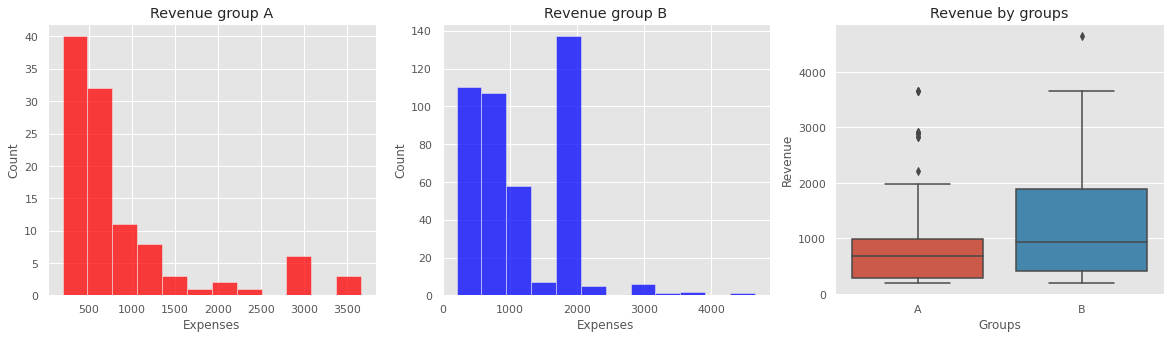

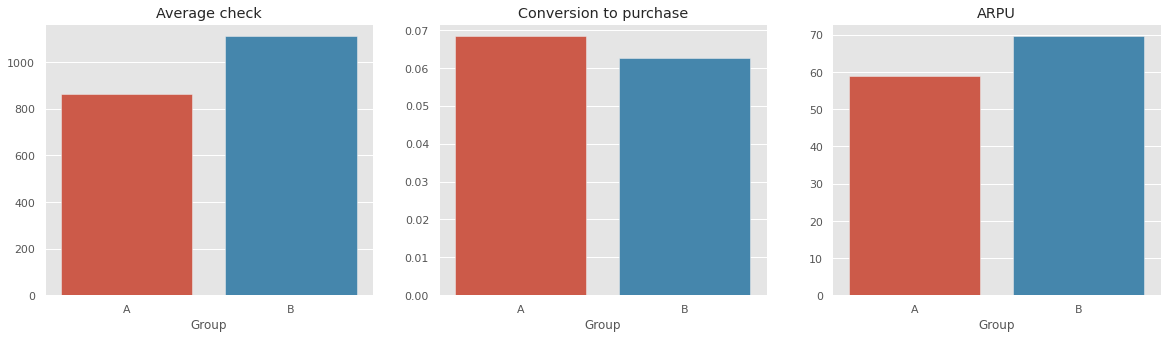

In [45]:
vizualization(metrics, data)